In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F


In [2]:
base_dir = "./flowers"
classes=os.listdir(base_dir)
num_class=len(classes)
print(num_class)

5


In [3]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
dataset = ImageFolder(base_dir, transform=transformer)

In [4]:
validation_size = 500
training_size = len(dataset) - validation_size

In [5]:
train_ds, val_ds_main = random_split(dataset,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[300, 200])
len(train_ds), len(val_ds)

(3817, 300)

In [6]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  rose (2)


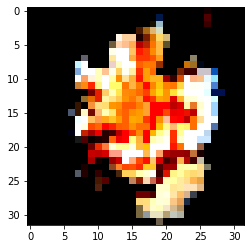

In [17]:
show_example(*dataset[2000])

In [8]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=30, stride=1)
        self.linear = nn.Linear(32, num_classes)
        

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.softmax(out, dim=1)

        return out
net = SimpleNet(num_classes=num_class)


In [9]:
def train(net, trainloader, epochs):
    """
    Train the network on the training set.
    """
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        running_loss =0.0
        for i, (images, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = net(images.unsqueeze(0))
            loss = criterion(outputs, torch.tensor([labels]))
            loss.backward()
            optimizer.step()
                    # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')

In [ ]:
#### training wihth 10 epochs

In [ ]:
train(net, train_ds, 10)


In [20]:
torch.save(net.state_dict(), 'flower.pth')

### Here is the code to recognize the flower


In [27]:
##### load model

In [28]:
save_path = './flower.pth'
net = SimpleNet(num_classes=num_class)
net.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [29]:
from PIL import Image
img_cat = Image.open("p1.jpeg").convert('RGB')
img_cat_preprocessed = transformer(img_cat)
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)
net.eval()
out = net(batch_img_cat_tensor)

In [30]:
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

tulip 37.8961181640625
